In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import plotly.express as px
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPool2D, ReLU, Dropout, AvgPool2D, Dense, Input, Flatten, Add, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from keras.utils.vis_utils import plot_model

#### Loading dataset
Download dataset at [FER-2013](https://www.kaggle.com/datasets/msambare/fer2013) <br/>
Add Path locations to the dataset folder

In [6]:
train_dir = """ Add Path to train directory of dataset """
test_dir = """ Add Path to test directory of dataset """
model_path = """ Add Path to save models """

CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 100
FINE_TUNING_EPOCHS = 20 
LR = 0.001
NUM_CLASSES = len(CLASS_LABELS)
EARLY_STOPPING_CRITERIA = 3

In [4]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


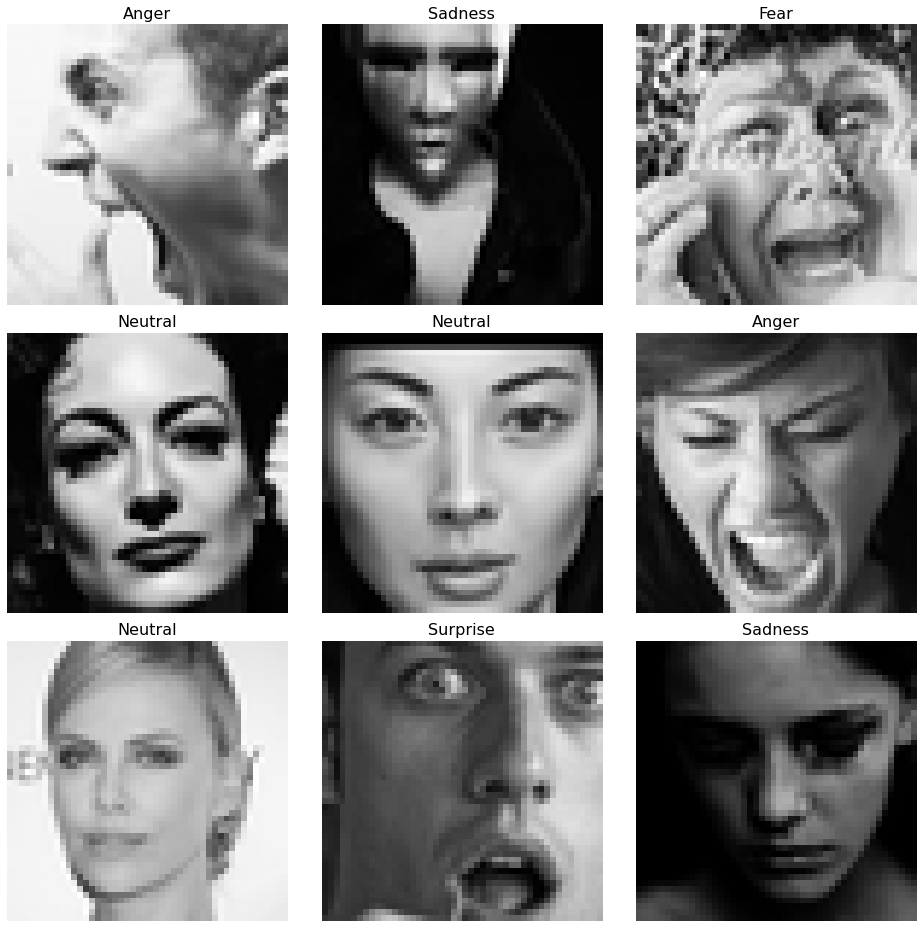

In [5]:

# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale=1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

In [6]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### EmotionNet

In [54]:
def EmotionNet(optimizer):

    input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    L1 = Conv2D(11, kernel_size = 3, padding="same")(input)
    L2 = Conv2D(9, kernel_size = 3, padding="same")(L1)
    L3 = Conv2D(11, kernel_size = 3, padding="same")(L2)
    L4_ip = Add()([L1, L3])
    L4 = Conv2D(8, kernel_size = 3, padding="same")(L4_ip)
    L5 = Conv2D(11, kernel_size = 3, padding="same")(L4)
    L6_ip = Add()([L1, L3, L5])
    L6 = Conv2D(7, kernel_size = 3, padding="same")(L6_ip)
    L7 = Conv2D(11, kernel_size = 3, padding="same")(L6)    
    L8_ip = Add()([L1, L3, L5, L7])
    Li_1 = Conv2D(27, kernel_size=1, strides=2, padding="same")(L8_ip)
    L8 = Conv2D(14, kernel_size = 3, strides=2, padding="same")(L8_ip)
    L9 = Conv2D(27, kernel_size = 3, padding="same")(L8)
    L10_ip = Add()([L9, Li_1])
    L10 = Conv2D(19, kernel_size = 3, padding="same")(L10_ip)
    L11 = Conv2D(27, kernel_size = 3, padding="same")(L10)
    L12_ip = Add()([L9, L11])
    L12 = Conv2D(26, kernel_size = 3, padding="same")(L12_ip)
    L13 = Conv2D(27, kernel_size = 3, padding="same")(L12)    
    Li_2_ip = Add()([L9, L11, L13, Li_1])
    Li_2 = Conv2D(64, kernel_size=1, strides=2, padding="same")(Li_2_ip)
    L14_ip = Add()([L9, L11, L13, Li_1])
    L14 = Conv2D(36, kernel_size = 3, strides=2, padding="same")(L14_ip)
    L15 = Conv2D(64, kernel_size = 3, padding="same")(L14)
    L16_ip = Add()([Li_2, L15])
    L16 = Conv2D(39, kernel_size = 3, padding="same")(L16_ip)
    L17 = Conv2D(64, kernel_size = 3, padding="same")(L16)
    L18_ip = Add()([L15, L17, Li_2])
    L18 = Conv2D(24, kernel_size = 3, padding="same")(L18_ip)
    L19 = Conv2D(64, kernel_size = 3, padding="same")(L18)
    L20_ip = Add()([L15, L17, Li_2, L19])
    L20 = AvgPool2D(pool_size=12)(L20_ip)
    
    F = Flatten()(L20)
    output = Dense(NUM_CLASSES, activation='softmax')(F)
    
    model = Model(input, output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [58]:
model = EmotionNet(Adam(lr=1e-3))
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d_147 (Conv2D)            (None, 48, 48, 11)   308         ['input_10[0][0]']               
                                                                                                  
 conv2d_148 (Conv2D)            (None, 48, 48, 9)    900         ['conv2d_147[0][0]']             
                                                                                                  
 conv2d_149 (Conv2D)            (None, 48, 48, 11)   902         ['conv2d_148[0][0]']             
                                                                                            

                                                                  'conv2d_165[0][0]',             
                                                                  'conv2d_161[0][0]',             
                                                                  'conv2d_167[0][0]']             
                                                                                                  
 average_pooling2d_7 (AveragePo  (None, 1, 1, 64)    0           ['add_79[0][0]']                 
 oling2D)                                                                                         
                                                                                                  
 flatten (Flatten)              (None, 64)           0           ['average_pooling2d_7[0][0]']    
                                                                                                  
 dense_6 (Dense)                (None, 7)            455         ['flatten[0][0]']                
          

In [62]:
model = EmotionNet(Adam(lr=1e-4))
model.fit(x = train_generator,
        epochs = EPOCHS ,
        validation_data = validation_generator)

Epoch 1/100
359/359 [==============================] - 145s 401ms/step - loss: 1.7993 - accuracy: 0.2500 - val_loss: 1.7896 - val_accuracy: 0.2487
Epoch 2/100
359/359 [==============================] - 149s 414ms/step - loss: 1.7868 - accuracy: 0.2544 - val_loss: 1.7922 - val_accuracy: 0.2519
Epoch 3/100
359/359 [==============================] - 170s 474ms/step - loss: 1.7832 - accuracy: 0.2532 - val_loss: 1.7828 - val_accuracy: 0.2520
Epoch 4/100
359/359 [==============================] - 194s 539ms/step - loss: 1.7789 - accuracy: 0.2572 - val_loss: 1.7813 - val_accuracy: 0.2644
Epoch 5/100
359/359 [==============================] - 204s 567ms/step - loss: 1.7679 - accuracy: 0.2672 - val_loss: 1.7506 - val_accuracy: 0.2885
Epoch 6/100
359/359 [==============================] - 203s 565ms/step - loss: 1.7477 - accuracy: 0.2899 - val_loss: 1.7356 - val_accuracy: 0.3076
Epoch 7/100
359/359 [==============================] - 203s 564ms/step - loss: 1.7405 - accuracy: 0.2957 - val_loss: 1

### Adding more dense layers to EmotionNet

In [63]:
def EmotionNetMod(optimizer):

    input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    L1 = Conv2D(11, kernel_size = 3, padding="same")(input)
    L2 = Conv2D(9, kernel_size = 3, padding="same")(L1)
    L3 = Conv2D(11, kernel_size = 3, padding="same")(L2)
    L4_ip = Add()([L1, L3])
    L4 = Conv2D(8, kernel_size = 3, padding="same")(L4_ip)
    L5 = Conv2D(11, kernel_size = 3, padding="same")(L4)
    L6_ip = Add()([L1, L3, L5])
    L6 = Conv2D(7, kernel_size = 3, padding="same")(L6_ip)
    L7 = Conv2D(11, kernel_size = 3, padding="same")(L6)    
    L8_ip = Add()([L1, L3, L5, L7])
    Li_1 = Conv2D(27, kernel_size=1, strides=2, padding="same")(L8_ip)
    L8 = Conv2D(14, kernel_size = 3, strides=2, padding="same")(L8_ip)
    L9 = Conv2D(27, kernel_size = 3, padding="same")(L8)
    L10_ip = Add()([L9, Li_1])
    L10 = Conv2D(19, kernel_size = 3, padding="same")(L10_ip)
    L11 = Conv2D(27, kernel_size = 3, padding="same")(L10)
    L12_ip = Add()([L9, L11])
    L12 = Conv2D(26, kernel_size = 3, padding="same")(L12_ip)
    L13 = Conv2D(27, kernel_size = 3, padding="same")(L12)    
    Li_2_ip = Add()([L9, L11, L13, Li_1])
    Li_2 = Conv2D(64, kernel_size=1, strides=2, padding="same")(Li_2_ip)
    L14_ip = Add()([L9, L11, L13, Li_1])
    L14 = Conv2D(36, kernel_size = 3, strides=2, padding="same")(L14_ip)
    L15 = Conv2D(64, kernel_size = 3, padding="same")(L14)
    L16_ip = Add()([Li_2, L15])
    L16 = Conv2D(39, kernel_size = 3, padding="same")(L16_ip)
    L17 = Conv2D(64, kernel_size = 3, padding="same")(L16)
    L18_ip = Add()([L15, L17, Li_2])
    L18 = Conv2D(24, kernel_size = 3, padding="same")(L18_ip)
    L19 = Conv2D(64, kernel_size = 3, padding="same")(L18)
    L20_ip = Add()([L15, L17, Li_2, L19])
    L20 = AvgPool2D(pool_size=12)(L20_ip)
    
    F = Flatten()(L20)
    L21 = Dense(256, activation='relu')(F)
    L22 = Dense(128, activation='relu')(L21)
    L23 = Dense(64, activation='relu')(L22)
    L24 = Dense(32, activation='relu')(L23)
    output = Dense(NUM_CLASSES, activation='softmax')(L24)
    
    model = Model(input, output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [64]:
model = EmotionNetMod(Adam(lr=1e-3))
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d_231 (Conv2D)            (None, 48, 48, 11)   308         ['input_14[0][0]']               
                                                                                                  
 conv2d_232 (Conv2D)            (None, 48, 48, 9)    900         ['conv2d_231[0][0]']             
                                                                                                  
 conv2d_233 (Conv2D)            (None, 48, 48, 11)   902         ['conv2d_232[0][0]']             
                                                                                           

                                                                  'conv2d_249[0][0]',             
                                                                  'conv2d_245[0][0]',             
                                                                  'conv2d_251[0][0]']             
                                                                                                  
 average_pooling2d_11 (AverageP  (None, 1, 1, 64)    0           ['add_119[0][0]']                
 ooling2D)                                                                                        
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d_11[0][0]']   
                                                                                                  
 dense_10 (Dense)               (None, 256)          16640       ['flatten_4[0][0]']              
          

In [65]:
model.fit(x = train_generator,
        epochs = EPOCHS ,
        validation_data = validation_generator)

Epoch 1/100
359/359 [==============================] - 177s 478ms/step - loss: 1.8120 - accuracy: 0.2478 - val_loss: 1.8251 - val_accuracy: 0.2273
Epoch 2/100
359/359 [==============================] - 169s 472ms/step - loss: 1.7965 - accuracy: 0.2500 - val_loss: 1.7961 - val_accuracy: 0.2501
Epoch 3/100
359/359 [==============================] - 202s 563ms/step - loss: 1.7874 - accuracy: 0.2554 - val_loss: 1.7640 - val_accuracy: 0.2811
Epoch 4/100
359/359 [==============================] - 214s 597ms/step - loss: 1.7653 - accuracy: 0.2761 - val_loss: 1.7624 - val_accuracy: 0.2716
Epoch 5/100
359/359 [==============================] - 244s 680ms/step - loss: 1.7542 - accuracy: 0.2848 - val_loss: 1.7260 - val_accuracy: 0.3141
Epoch 6/100
359/359 [==============================] - 241s 671ms/step - loss: 1.7336 - accuracy: 0.3027 - val_loss: 1.7021 - val_accuracy: 0.3200
Epoch 7/100
359/359 [==============================] - 244s 678ms/step - loss: 1.7169 - accuracy: 0.3099 - val_loss: 1

In [66]:
model.fit(x = train_generator,
        epochs = EPOCHS ,
        validation_data = validation_generator)

Epoch 1/100
359/359 [==============================] - 202s 564ms/step - loss: 1.3610 - accuracy: 0.4727 - val_loss: 1.5406 - val_accuracy: 0.4173
Epoch 2/100
359/359 [==============================] - 198s 553ms/step - loss: 1.3559 - accuracy: 0.4756 - val_loss: 1.5422 - val_accuracy: 0.4173
Epoch 3/100
359/359 [==============================] - 198s 551ms/step - loss: 1.3470 - accuracy: 0.4821 - val_loss: 1.5563 - val_accuracy: 0.4184
Epoch 4/100
359/359 [==============================] - 200s 556ms/step - loss: 1.3507 - accuracy: 0.4764 - val_loss: 1.5445 - val_accuracy: 0.4180
Epoch 5/100
359/359 [==============================] - 199s 553ms/step - loss: 1.3412 - accuracy: 0.4813 - val_loss: 1.5748 - val_accuracy: 0.4126
Epoch 6/100
359/359 [==============================] - 199s 555ms/step - loss: 1.3464 - accuracy: 0.4793 - val_loss: 1.5309 - val_accuracy: 0.4168
Epoch 7/100
359/359 [==============================] - 199s 555ms/step - loss: 1.3542 - accuracy: 0.4776 - val_loss: 1

### Simple ConvNet

In [46]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_101 (Conv2D)         (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_102 (Conv2D)         (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_103 (Conv2D)         (None, 8, 8, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 4096)             

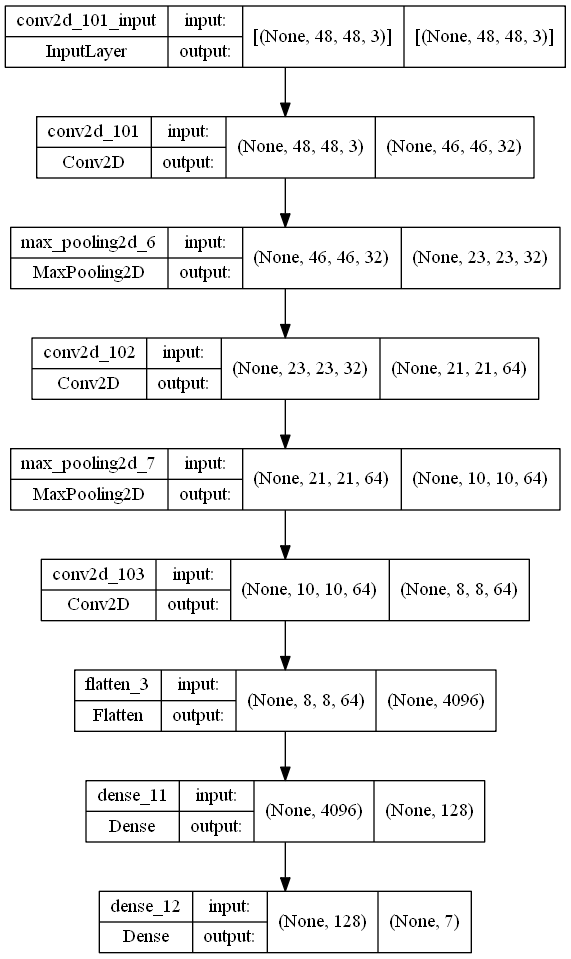

In [47]:
plot_model(model, to_file='SimpleConv_plot.png', show_shapes=True, show_layer_names=True)

In [77]:
model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

history = model.fit_generator(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
)

Epoch 1/30


C:\Users\HAEMANTH\AppData\Local\Temp\ipykernel_12756\343566595.py:6: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



359/359 [==============================] - 45s 125ms/step - loss: 1.7753 - accuracy: 0.2704 - val_loss: 1.6936 - val_accuracy: 0.3311
Epoch 2/30
359/359 [==============================] - 49s 136ms/step - loss: 1.6725 - accuracy: 0.3373 - val_loss: 1.6175 - val_accuracy: 0.3639
Epoch 3/30
359/359 [==============================] - 47s 132ms/step - loss: 1.6088 - accuracy: 0.3716 - val_loss: 1.5378 - val_accuracy: 0.4074
Epoch 4/30
359/359 [==============================] - 50s 139ms/step - loss: 1.5550 - accuracy: 0.3939 - val_loss: 1.4928 - val_accuracy: 0.4329
Epoch 5/30
359/359 [==============================] - 48s 134ms/step - loss: 1.5108 - accuracy: 0.4163 - val_loss: 1.4471 - val_accuracy: 0.4477
Epoch 6/30
359/359 [==============================] - 55s 152ms/step - loss: 1.4719 - accuracy: 0.4293 - val_loss: 1.4218 - val_accuracy: 0.4478
Epoch 7/30
359/359 [==============================] - 56s 156ms/step - loss: 1.4352 - accuracy: 0.4497 - val_loss: 1.3813 - val_accuracy: 0.4

In [78]:
model.fit_generator(
    train_generator,
    epochs=70,
    validation_data=validation_generator,
)

Epoch 1/70


C:\Users\HAEMANTH\AppData\Local\Temp\ipykernel_12756\3375135533.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



359/359 [==============================] - 57s 158ms/step - loss: 1.0890 - accuracy: 0.5914 - val_loss: 1.1873 - val_accuracy: 0.5560
Epoch 2/70
359/359 [==============================] - 57s 158ms/step - loss: 1.0851 - accuracy: 0.5929 - val_loss: 1.1772 - val_accuracy: 0.5682
Epoch 3/70
359/359 [==============================] - 56s 156ms/step - loss: 1.0779 - accuracy: 0.5970 - val_loss: 1.1607 - val_accuracy: 0.5741
Epoch 4/70
359/359 [==============================] - 56s 156ms/step - loss: 1.0652 - accuracy: 0.6018 - val_loss: 1.1745 - val_accuracy: 0.5750
Epoch 5/70
359/359 [==============================] - 56s 155ms/step - loss: 1.0662 - accuracy: 0.5985 - val_loss: 1.1579 - val_accuracy: 0.5806
Epoch 6/70
359/359 [==============================] - 55s 153ms/step - loss: 1.0568 - accuracy: 0.6030 - val_loss: 1.1691 - val_accuracy: 0.5678
Epoch 7/70
359/359 [==============================] - 57s 157ms/step - loss: 1.0520 - accuracy: 0.6098 - val_loss: 1.1784 - val_accuracy: 0.5

In [79]:
model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
)

Epoch 1/50


C:\Users\HAEMANTH\AppData\Local\Temp\ipykernel_12756\1551093246.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



359/359 [==============================] - 50s 138ms/step - loss: 0.8545 - accuracy: 0.6871 - val_loss: 1.2787 - val_accuracy: 0.5692
Epoch 2/50
359/359 [==============================] - 55s 154ms/step - loss: 0.8562 - accuracy: 0.6816 - val_loss: 1.2317 - val_accuracy: 0.5788
Epoch 3/50
359/359 [==============================] - 56s 156ms/step - loss: 0.8519 - accuracy: 0.6866 - val_loss: 1.2268 - val_accuracy: 0.5774
Epoch 4/50
359/359 [==============================] - 56s 155ms/step - loss: 0.8546 - accuracy: 0.6859 - val_loss: 1.2753 - val_accuracy: 0.5602
Epoch 5/50
359/359 [==============================] - 56s 157ms/step - loss: 0.8458 - accuracy: 0.6889 - val_loss: 1.2511 - val_accuracy: 0.5847
Epoch 6/50
359/359 [==============================] - 55s 154ms/step - loss: 0.8471 - accuracy: 0.6869 - val_loss: 1.2763 - val_accuracy: 0.5820
Epoch 7/50
359/359 [==============================] - 65s 180ms/step - loss: 0.8532 - accuracy: 0.6856 - val_loss: 1.2372 - val_accuracy: 0.5

In [83]:
resultPath = """ Add Path to save models here """
modelPath = os.path.join(resultPath, 'SimpleConv_150Epochs.h5')
model.save(modelPath)

### Complex ConvNet

In [44]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_97 (Conv2D)          (None, 23, 23, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 23, 23, 64)      

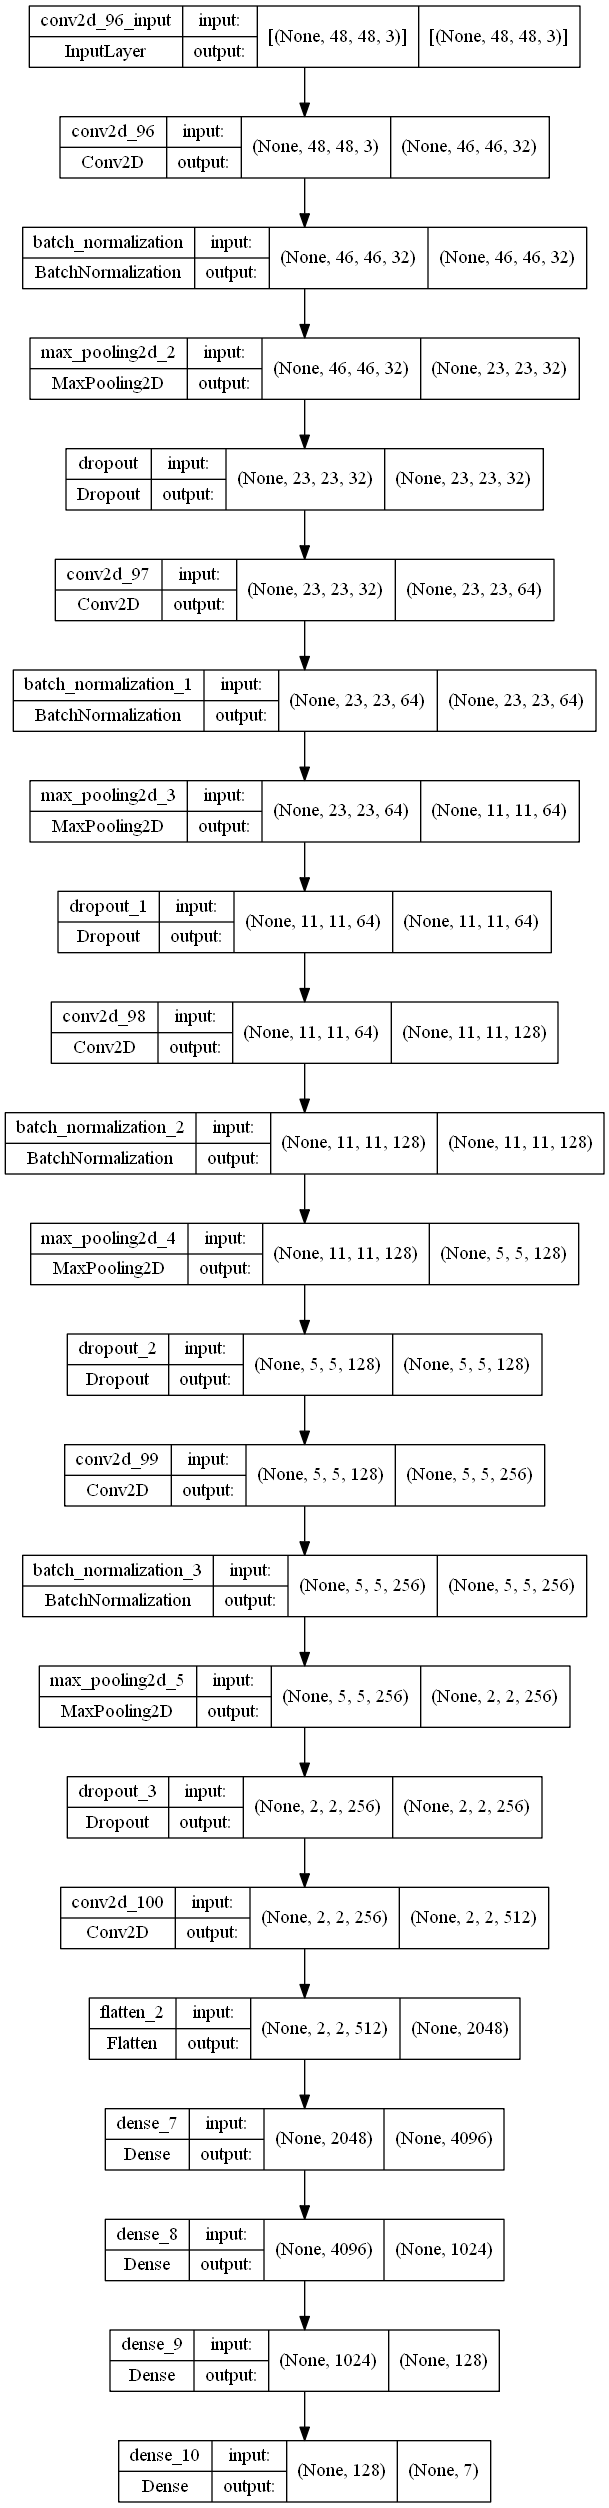

In [45]:
plot_model(model, to_file='ComplexConv_plot.png', show_shapes=True, show_layer_names=True)

In [94]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
)

Epoch 1/100


C:\Users\HAEMANTH\AppData\Local\Temp\ipykernel_12756\644517337.py:2: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



359/359 [==============================] - 143s 376ms/step - loss: 1.7924 - accuracy: 0.2528 - val_loss: 2.0084 - val_accuracy: 0.2513
Epoch 2/100
359/359 [==============================] - 148s 413ms/step - loss: 1.7355 - accuracy: 0.2927 - val_loss: 1.7699 - val_accuracy: 0.2888
Epoch 3/100
359/359 [==============================] - 158s 439ms/step - loss: 1.6622 - accuracy: 0.3398 - val_loss: 1.6271 - val_accuracy: 0.3586
Epoch 4/100
359/359 [==============================] - 162s 452ms/step - loss: 1.6017 - accuracy: 0.3698 - val_loss: 1.5221 - val_accuracy: 0.4100
Epoch 5/100
359/359 [==============================] - 163s 453ms/step - loss: 1.5579 - accuracy: 0.3936 - val_loss: 1.6700 - val_accuracy: 0.3357
Epoch 6/100
359/359 [==============================] - 163s 453ms/step - loss: 1.5194 - accuracy: 0.4103 - val_loss: 1.9974 - val_accuracy: 0.2372
Epoch 7/100
359/359 [==============================] - 160s 445ms/step - loss: 1.4823 - accuracy: 0.4235 - val_loss: 1.3905 - val_

In [95]:
modelPath = os.path.join(resultPath, 'ComplexConv_100Epochs.h5')
model.save(modelPath)

### Modified with EmotionNet

In [7]:
def EmotionNetNew(optimizer):

    input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    L1 = Conv2D(24, kernel_size = 3, padding="same")(input)
    L2 = Conv2D(18, kernel_size = 3, padding="same")(L1)
    L3 = Conv2D(24, kernel_size = 3, padding="same")(L2)
    L4_ip = Add()([L1, L3])
    L4_ip = BatchNormalization()(L4_ip)
    L4 = Conv2D(16, kernel_size = 3, padding="same")(L4_ip)
    L5 = Conv2D(24, kernel_size = 3, padding="same")(L4)
    L6_ip = Add()([L1, L3, L5])
    L6_ip = BatchNormalization()(L6_ip)
    L6 = Conv2D(14, kernel_size = 3, padding="same")(L6_ip)
    L7 = Conv2D(24, kernel_size = 3, padding="same")(L6)    
    L8_ip = Add()([L1, L3, L5, L7])
    L8_ip = BatchNormalization()(L8_ip)
    L8 = Conv2D(32, kernel_size = 3, strides=2, padding="same")(L8_ip)
    L9 = Conv2D(64, kernel_size = 3, padding="same")(L8)
    Li_1 = Conv2D(64, kernel_size=1, strides=2, padding="same")(L8_ip)
    L10_ip = Add()([L9, Li_1])
    L10_ip = BatchNormalization()(L10_ip)
    L10 = Conv2D(38, kernel_size = 3, padding="same")(L10_ip)
    L11 = Conv2D(64, kernel_size = 3, padding="same")(L10)
    L12_ip = Add()([L9, L11])
    L12_ip = BatchNormalization()(L12_ip)
    L12 = Conv2D(52, kernel_size = 3, padding="same")(L12_ip)
    L13 = Conv2D(64, kernel_size = 3, padding="same")(L12)    
    L14_ip = Add()([L9, L11, L13, Li_1])
    L14_ip = BatchNormalization()(L14_ip)
    L14 = Conv2D(72, kernel_size = 3, strides=2, padding="same")(L14_ip)
    Li_2_ip = Add()([L9, L11, L13, Li_1])
    Li_2_ip = BatchNormalization()(Li_2_ip)
    Li_2 = Conv2D(256, kernel_size=1, strides=2, padding="same")(Li_2_ip)
    L15 = Conv2D(256, kernel_size = 3, padding="same")(L14)
    L16_ip = Add()([Li_2, L15])
    L16_ip = BatchNormalization()(L16_ip)
    L16 = Conv2D(90, kernel_size = 3, padding="same")(L16_ip)
    L17 = Conv2D(256, kernel_size = 3, padding="same")(L16)
    L18_ip = Add()([L15, L17, Li_2])
    L18_ip = BatchNormalization()(L18_ip)
    L18 = Conv2D(64, kernel_size = 3, padding="same")(L18_ip)
    L19 = Conv2D(256, kernel_size = 3, padding="same")(L18)
    L20_ip = Add()([L15, L17, Li_2, L19])
    L20_ip = BatchNormalization()(L20_ip)
    L20 = AvgPool2D(pool_size=12)(L20_ip)
    
    F = Flatten()(L20)
    L21 = Dense(512, activation='relu')(F)
    L22 = Dense(256, activation='relu')(L21)
    L23 = Dense(128, activation='relu')(L22)
    L24 = Dense(64, activation='relu')(L23)
    L25 = Dense(32, activation='relu')(L24)
    output = Dense(NUM_CLASSES, activation='softmax')(L25)
    
    model = Model(input, output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [8]:
model = EmotionNetNew(Adam(lr=1e-3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 24)   672         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 48, 18)   3906        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 48, 48, 24)   3912        ['conv2d_1[0][0]']               
                                                                                              

                                                                                                  
 conv2d_16 (Conv2D)             (None, 12, 12, 256)  166144      ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_15 (Conv2D)             (None, 12, 12, 256)  16640       ['batch_normalization_6[0][0]']  
                                                                                                  
 add_7 (Add)                    (None, 12, 12, 256)  0           ['conv2d_15[0][0]',              
                                                                  'conv2d_16[0][0]']              
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 12, 12, 256)  1024       ['add_7[0][0]']                  
 rmalization)                                                                                     
          

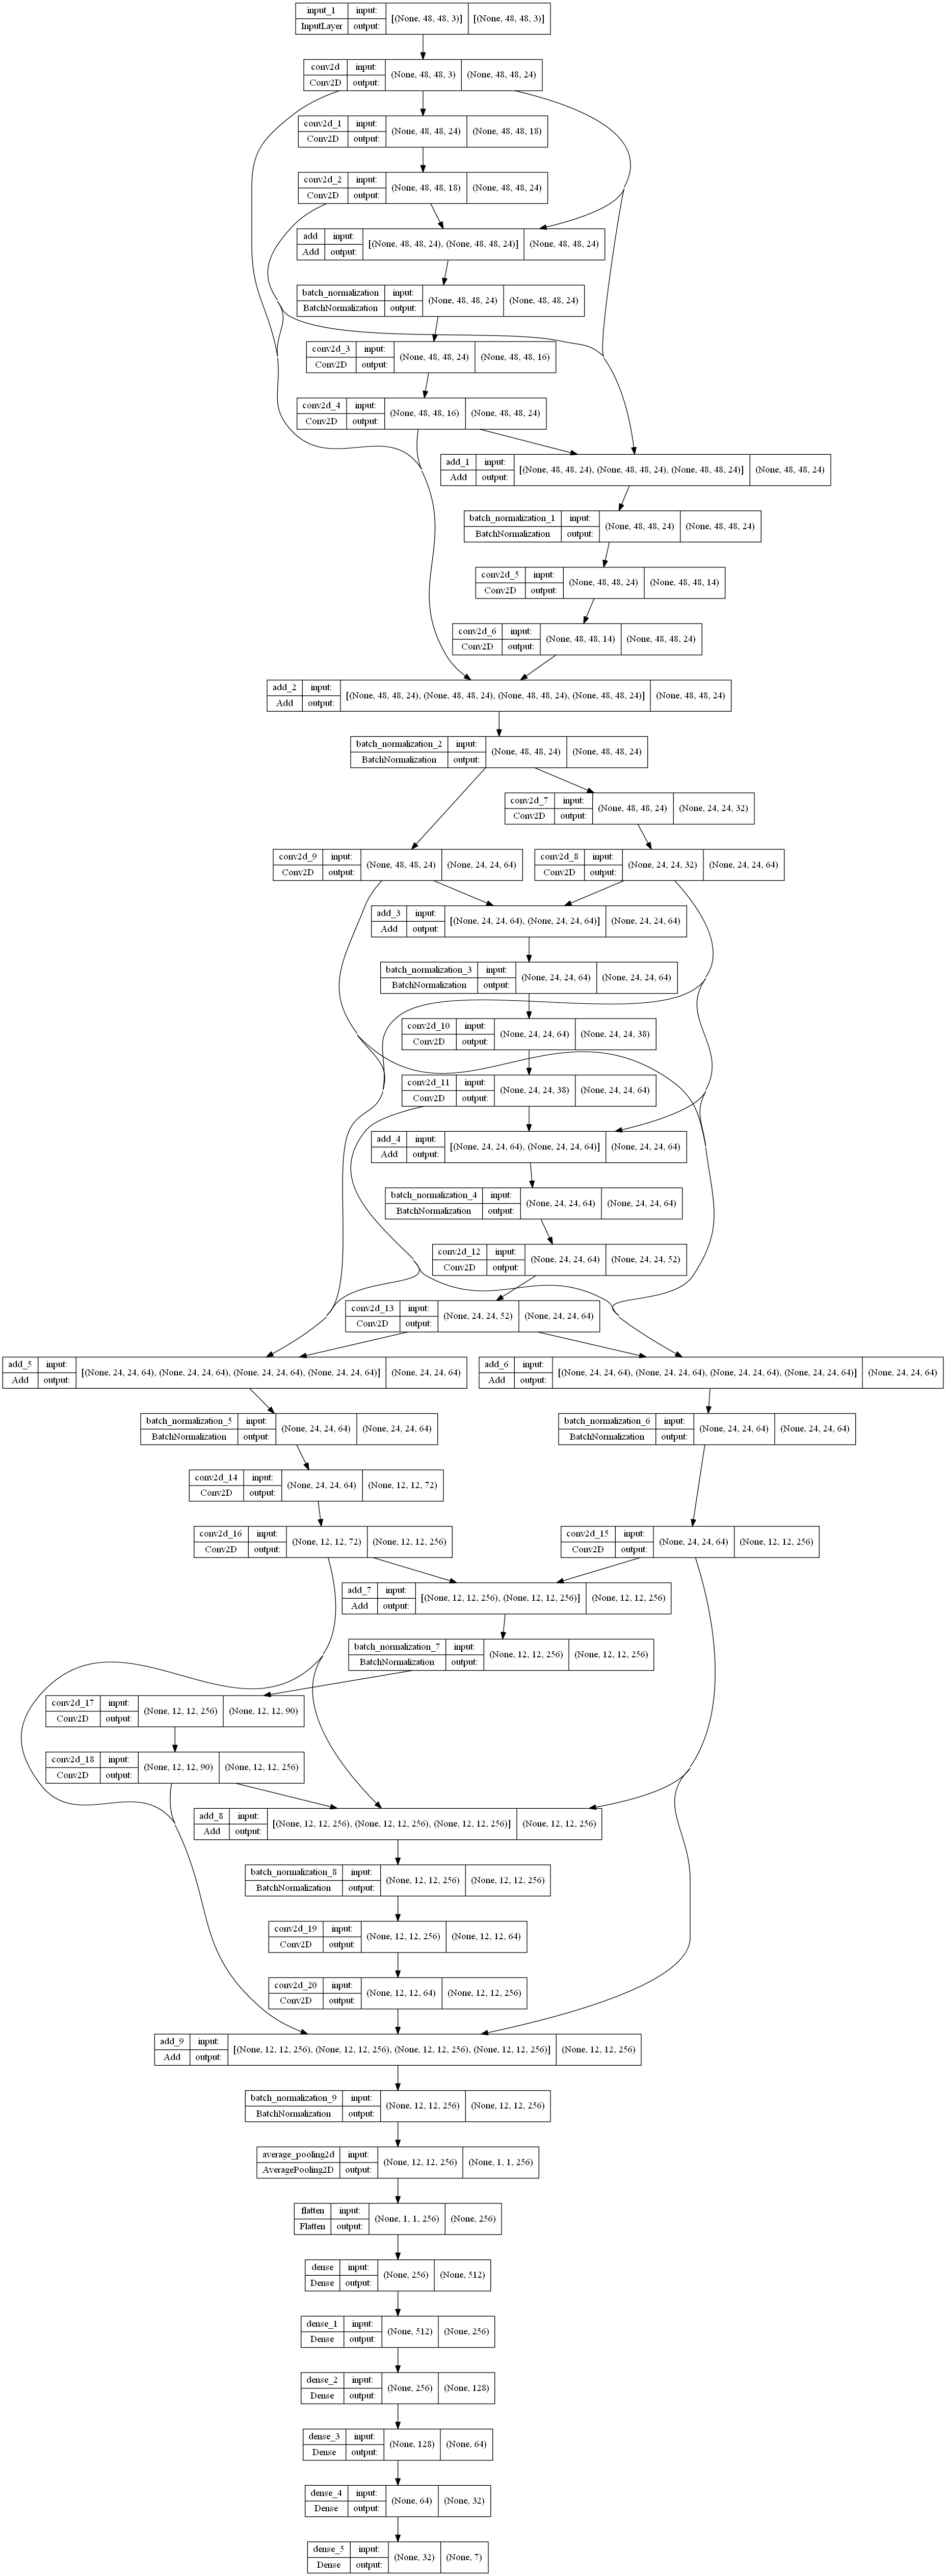

In [9]:
plot_model(model, to_file='EmotionNetNew_plot.png', show_shapes=True, show_layer_names=True)

In [6]:
model = tf.keras.models.load_model('C:/Users/HAEMANTH/Documents/NITT/Sem 7/CSPE72 - Deep Learning/Project/models/ComplexConv_100Epochs.h5')

In [35]:
model_2 = tf.keras.models.load_model('C:/Users/HAEMANTH/Documents/NITT/Sem 7/CSPE72 - Deep Learning/Project/models/EmotionNet_200Epochs.h5')
model_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d_126 (Conv2D)            (None, 48, 48, 24)   672         ['input_10[0][0]']               
                                                                                                  
 conv2d_127 (Conv2D)            (None, 48, 48, 18)   3906        ['conv2d_126[0][0]']             
                                                                                                  
 conv2d_128 (Conv2D)            (None, 48, 48, 24)   3912        ['conv2d_127[0][0]']             
                                                                                            

                                                                  'conv2d_144[0][0]',             
                                                                  'conv2d_140[0][0]',             
                                                                  'conv2d_146[0][0]']             
                                                                                                  
 average_pooling2d_3 (AveragePo  (None, 1, 1, 256)   0           ['add_65[0][0]']                 
 oling2D)                                                                                         
                                                                                                  
 flatten_3 (Flatten)            (None, 256)          0           ['average_pooling2d_3[0][0]']    
                                                                                                  
 dense_18 (Dense)               (None, 512)          131584      ['flatten_3[0][0]']              
          

In [62]:
model_2.compile(loss='categorical_crossentropy', metrics=['accuracy'])
res = model_2.evaluate(validation_generator)

90/90 [==============================] - 43s 441ms/step - loss: 1.7279 - accuracy: 0.4266


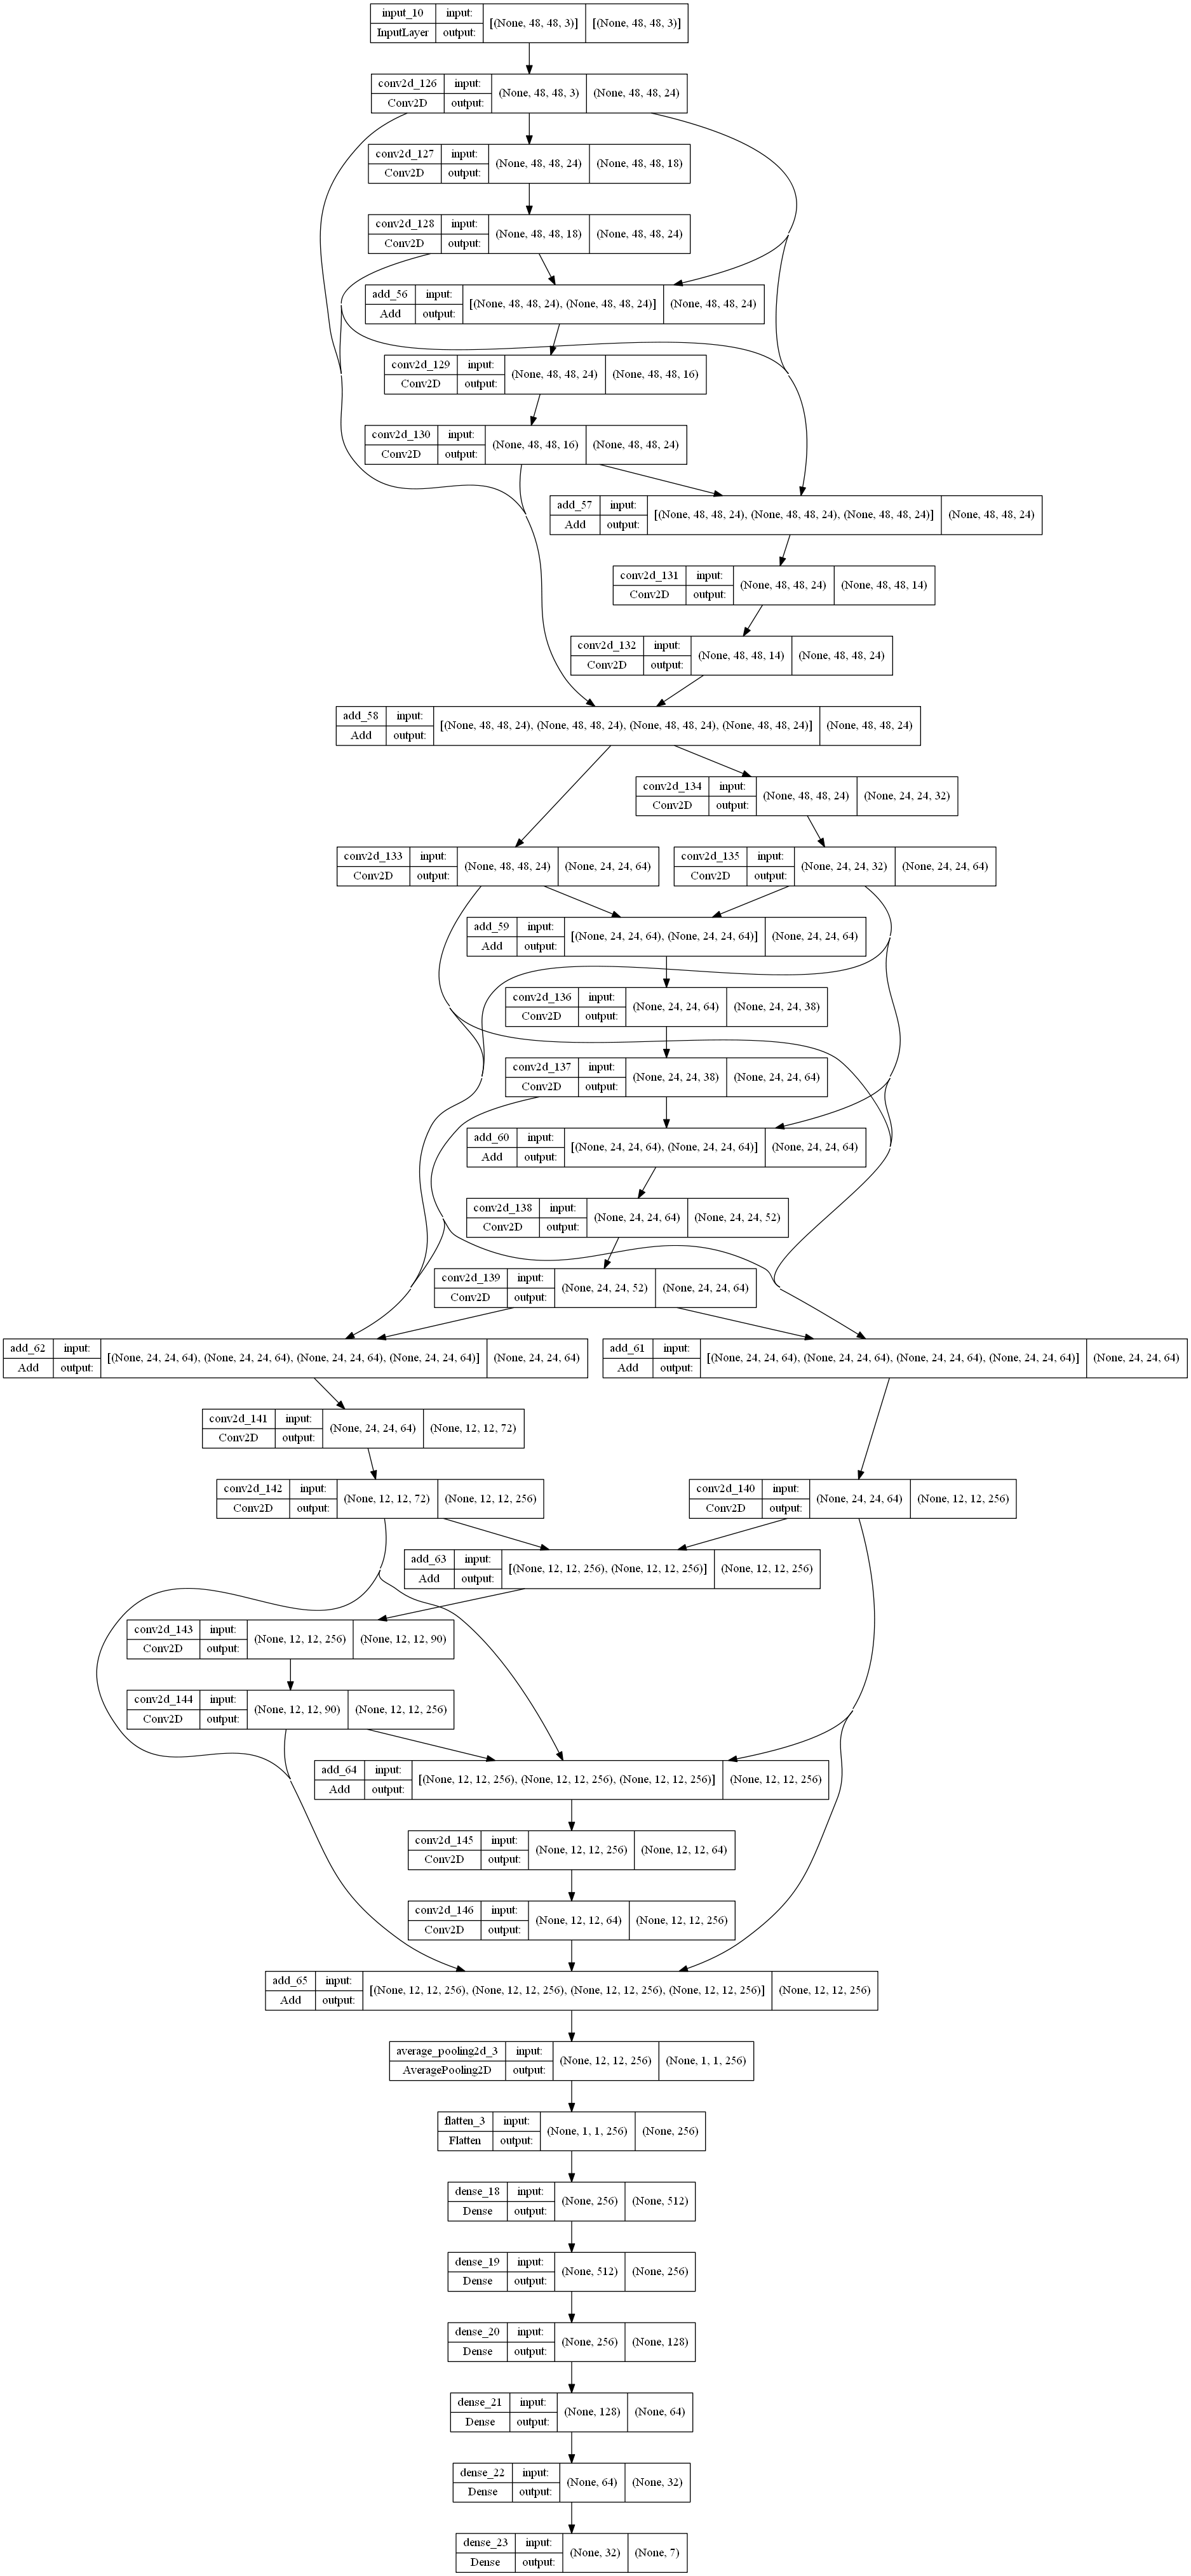

In [39]:
plot_model(model_2, to_file='EmotionNetNanoModified_plot.png', show_shapes=True, show_layer_names=True)